# HW4P1: Language Modelling

Welcome to the final part 1 hw of this course. This is the only part 1 in which you have PyTorch training (Yay). You will be working on training language models and evaluating them on the task of prediction and generation.<br>
Note: A major change which we have made this semester is that we have made the model which you will be coding in this HW very similar to the Speller module from HW4P2.

# Get modules and datasets

In [ ]:
# !pip install torchsummaryX
# !pip install pytorch-nlp

In [ ]:
# TODO: Import drive if you are using Colab

# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
# drive.flush_and_unmount()

In [ ]:
# !tar -xvf /content/HW4/handout.tar -C /content/HW4/

In [ ]:
import sys
sys.path.append("/content/HW4/handout/") # TODO: Add path to handout/

In [ ]:
print(sys.path)

['/content', '/env/python', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.8/dist-packages/IPython/extensions', '/root/.ipython', '/content/HW4/handout/']


In [ ]:
%matplotlib inline

import torch

import os

import time
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import torchsummaryX
import math
from torchnlp.nn import LockedDropout

# Importing necessary modules from hw4
from hw4.tests_hw4 import test_prediction, test_generation

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", DEVICE)

Device:  cuda


In [ ]:
%cd /content/HW4/handout

/content/HW4/handout


# Load datasets

In [ ]:
# Loading the vocabulary. Try printing and see
VOCAB       = np.load('dataset/vocab.npy')

# We have also included <sos> and <eos> in the vocabulary for you
# However in real life, you include it explicitly if not provided
SOS_TOKEN   = np.where(VOCAB == '<sos>')[0][0]
EOS_TOKEN   = np.where(VOCAB == '<eos>')[0][0]
NUM_WORDS   = len(VOCAB) - 2 # Actual number of words in vocabulary

print("Vocab length: ", len(VOCAB))
print(VOCAB)
print(''.join(VOCAB[:20]))

Vocab length:  33280
['!' '"' '#' ... '～' '<sos>' '<eos>']
!"#$%&''Addario'Africaine'Andrade'Automobile'Brien'Carmel'Connell'Connor'Cruz'Day'Dell'Donnell'Italia


In [ ]:
# Loding the training dataset. Refer to write up section 2 to understand the structure
dataset     = np.load('dataset/wiki.train.npy', allow_pickle=True)

In [ ]:
print(len(dataset))
print(len(dataset[0]))
print(dataset[0])
print(type(dataset[0]))
print("\n")

## By default no blank characters
print(' '.join([VOCAB[i] for i in dataset[0]]))
print(' '.join([VOCAB[i] for i in dataset[1]]))
print(' '.join([VOCAB[i] for i in dataset[2]]))

579
3803
[ 1420 13859  3714 ...   813    79  1417]
<class 'numpy.ndarray'>


= Valkyria Chronicles III = <eol> Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . <unk> the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " <unk> Raven " . <eol> The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multi

In [ ]:
##** Adding <sos> and <eos> (integer symbols) before the start and end of every sentence in dataset **##
for i in range(len(dataset)):
    dataset[i] = np.insert(dataset[i], 0, SOS_TOKEN)
    dataset[i] = np.append(dataset[i], EOS_TOKEN)

In [ ]:
print(dataset[0])
print(' '.join([VOCAB[i] for i in dataset[0]]))
print(' '.join([VOCAB[i] for i in dataset[1]]))

[33278  1420 13859 ...    79  1417 33279]
<sos> = Valkyria Chronicles III = <eol> Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . <unk> the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " <unk> Raven " . <eol> The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as mak

In [ ]:
# Loading the fixtures for validation and test - prediction
fixtures_pred       = np.load('fixtures/prediction.npz')        # validation
fixtures_pred_test  = np.load('fixtures/prediction_test.npz')   # test

print("Validation shapes    : ", fixtures_pred['inp'].shape, fixtures_pred['out'].shape)
print("Test shapes          : ", fixtures_pred_test['inp'].shape)
print(type(fixtures_pred))
print(list(fixtures_pred.keys()))

Validation shapes    :  (128, 21) (128,)
Test shapes          :  (128, 21)
<class 'numpy.lib.npyio.NpzFile'>
['inp', 'out']


In [ ]:
# Loading the fixtures for validation and test - generation
fixtures_gen        = np.load('fixtures/generation.npy')        # validation
fixtures_gen_test   = np.load('fixtures/generation_test.npy')   # test

print("Validation Gen Shapes    :", fixtures_gen.shape)
print("Test Gen Shapes          :", fixtures_gen_test.shape)
print(type(fixtures_gen))

Validation Gen Shapes    : (32, 21)
Test Gen Shapes          : (128, 31)
<class 'numpy.ndarray'>


In [ ]:
for idx in range(5):
    print(' '.join(VOCAB[i] for i in fixtures_pred['inp'][idx]))
    print(VOCAB[fixtures_pred['out'][idx]])

<sos> output port of a section will generally not be the same . However , for a mid @-@ series section
(
<sos> a few from the Heavy <unk> Platoon and one or two from B Company . <unk> , 60 to 70
men
<sos> <unk> also produced monitors for use on the rivers , the first two of which differed from the ocean @-@
going
<sos> Head of <unk> . She had been converted from a commercial vessel in New Orleans for river and coastal fighting
.
<sos> the fight remains controversial , as <unk> tested positive for elevated levels of <unk> prior to his next fight .
<unk>


In [ ]:
for idx in range(10):
    print(' '.join(VOCAB[i] for i in fixtures_gen[idx]))

<sos> while the group was en route , but only three were ultimately able to attack . None of them were
<sos> <unk> , where he remained on loan until 30 June 2010 . <eol> = = = Return to Manchester United
<sos> 25 April 2013 , denoting shipments of 500 @,@ 000 copies . <eol> The song became One Direction 's fourth
<sos> , and Bruce R. ) one daughter ( Wendy J. <unk> ) and two grandchildren , died in <unk> ,
<sos> Warrior were examples of this type . Because their armor was so heavy , they could only carry a single
<sos> the embassy at 1 : 49 and landed on Guam at 2 : 23 ; twenty minutes later , Ambassador
<sos> <unk> , $ 96 million USD ) . Damage was heaviest in South Korea , notably where it moved ashore
<sos> The <unk> were condemned as <unk> by <unk> , who saw the riots as hampering attempts to resolve the situation
<sos> by a decision made by the War Office in mid @-@ 1941 , as it was considering the equipment to
<sos> Division crossed the <unk> at a number of places and climbed the

# Custom DataLoader

In [ ]:
class DataLoaderForLanguageModeling(torch.utils.data.DataLoader): # Inherit from torch.utils.data.DataLoader
    """
        TODO: Define data loader logic here
    """
    # Implementing a lot of pre processing in __init__() function to allow for
    # faster runtime
    def __init__(self, dataset, batch_size, seq_len, shuffle = True, drop_last= False):

        self.dataset    = dataset
        self.batch_size = batch_size
        self.seq_len    = seq_len
        self.shuffle    = shuffle
        self.drop_last  = drop_last
        self.full_len   = len(np.concatenate(self.dataset, axis = 0))

        if self.drop_last:
            self.n_batches  = ((self.full_len-1)//self.seq_len) // self.batch_size
        else:
            if ((self.full_len-1)//self.seq_len) % self.batch_size == 0:
                self.n_batches  = ((self.full_len-1)//self.seq_len) // self.batch_size
            else:
                self.n_batches  = (((self.full_len-1)//self.seq_len) // self.batch_size) + 1

    def __len__(self):
        # What output do you get when you print len(loader)? You get the number of batches
        # Your dataset has (579, ) articles and each article has a specified amount of words.
        # You concatenate the dataset and then batch parts of it according to the sequence length
        # TODO: return the number of batches
        # If you are using variable sequence_length, the length might not be fixed
        return self.n_batches

    def __iter__(self):

        # Shuffling dataset if shuffle is True
        if self.shuffle:
            np.random.shuffle(self.dataset)

        # Concatenating the dataset into one large text
        self.concat_dataset = np.concatenate(self.dataset, axis = 0)

        self.inputs, self.targets = [], []

        # Computing the final index length until which point we have the complete input, dropping the rest
        # Other solution could have been to pad with zeros to save information
        end_full_idx = ((len(self.concat_dataset)-1)//self.seq_len) * self.seq_len

        # Looping through the concatenated dataset to prepare inputs and targets
        for idx in range(0, end_full_idx, self.seq_len):
            self.inputs.append(self.concat_dataset[idx: idx + self.seq_len])
            self.targets.append(self.concat_dataset[idx+1: idx + 1 + self.seq_len])

        # Stacking the inputs and targets
        self.inputs = np.row_stack(self.inputs)
        self.targets = np.row_stack(self.targets)

        # Checking if the input length after stacking can be segmented into clean batches
        # If not padding the remaining if drop_last false
        if self.inputs.shape[0]%self.batch_size != 0:

            if self.drop_last:
                self.inputs = self.inputs[0: (self.inputs.shape[0]//self.batch_size) * self.batch_size]
                self.targets = self.targets[0: (self.inputs.shape[0]//self.batch_size) * self.batch_size]

            else:
                pad_width = self.batch_size - (self.inputs.shape[0]%self.batch_size)
                self.inputs = np.pad(self.inputs, ((0, pad_width) , (0, 0)), mode = 'constant', constant_values = (0, 0))
                self.targets = np.pad(self.targets, ((0, pad_width) , (0, 0)), mode = 'constant', constant_values = (0, 0))


        self.num_batches = self.inputs.shape[0] // self.batch_size

        for batch_idx in range(self.num_batches):
            input_tensors = torch.from_numpy(self.inputs[batch_idx*self.batch_size: (batch_idx+1)*self.batch_size])
            target_tensors = torch.from_numpy(self.targets[batch_idx*self.batch_size: (batch_idx+1)*self.batch_size])

            yield input_tensors, target_tensors

In [ ]:
# Some sanity checks

dl = DataLoaderForLanguageModeling(
    dataset     = dataset,
    batch_size  = 32,
    seq_len     = 10,
    shuffle     = True,
    drop_last   = True
)

inputs, targets = next(iter(dl))
print(inputs.shape, targets.shape)

for x, y in dl:
    print("x: ", ' '.join([VOCAB[i] for i in x[0]]))
    print("y: ", ' '.join([VOCAB[i] for i in y[0]]))
    break

torch.Size([32, 10]) torch.Size([32, 10])
x:  <sos> = Illinois ( Sufjan Stevens album ) = <eol>
y:  = Illinois ( Sufjan Stevens album ) = <eol> Illinois


# LanguageModel

In [ ]:
# Here comes the main portion of this HW.
# You can do this with a regular LSTM similar to HW3P2.
# However, using LSTMCells will make this Language model very similar to the decoder in HW4P2 and we recommend you use that for writing resuable code.

class LanguageModel(torch.nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout): # TODO: Add more parameters if you want
        super().__init__()

        self.dropout            = LockedDropout(dropout)

        # For all the layers which you will define, please read the documentation thoroughly before implementation
        self.token_embedding    = torch.nn.Embedding(num_embeddings = vocab_size, embedding_dim = embedding_dim, device = DEVICE)

        self.lstm_cells         = torch.nn.Sequential(
            *[torch.nn.LSTMCell(input_size = embedding_dim, hidden_size = hidden_dim, device = DEVICE) for i in range(num_layers)],
        )

        self.token_probability  = torch.nn.Linear(in_features = hidden_dim, out_features = vocab_size, bias = True, device = DEVICE) # TODO: Define the parameters

        self.token_probability.weight = self.token_embedding.weight


    # rnn_step is recursion through one timestep of RNN
    # It takes in embedding and previous hidden_states_list as input and using recursion computes
    # the new hidden_state as well as the network_output/embedding output of the last cell
    def rnn_step(self, embedding, hidden_states_list):

        if hidden_states_list == None:
            hidden_states_list      = [None] * len(self.lstm_cells)

        for i, lstm_cell in enumerate(self.lstm_cells):
            curr_hidden_state       = hidden_states_list[i]
            curr_hidden_state       = lstm_cell(embedding, curr_hidden_state)

            # Recusrion: Updating the hidden_states_list[i] and cell_states_list[i]
            embedding               = curr_hidden_state[0]
            hidden_states_list[i]   = curr_hidden_state

        return embedding, hidden_states_list

    # Given a token sequence x: <sos> t1 t2 t3 t4 ...... tn
    # Computing the probability of tn
    def predict(self, x):

        # x.shape = (batch_size, seq_len/timesteps)

        if not torch.is_tensor(x):
            x = torch.tensor(x).long().to(DEVICE)

        token_probability = 0

        with torch.inference_mode():
            hidden_states_list  = [None] * len(self.lstm_cells)

            for timestep in range(x.shape[1]):

                embedding                       = self.token_embedding(x[:, timestep])
                lstm_out, hidden_states_list    = self.rnn_step(embedding, hidden_states_list)
                token_probability               = self.token_probability(lstm_out)

            return token_probability

    def generate(self, x, timesteps):
        # Refer to section 1.3.2 to understand this function
        # Important Note: We do not draw <eos> from the distribution unlike the writeup
        if not torch.is_tensor(x):
            x = torch.tensor(x).long().to(DEVICE)

        # TODO: Pass the input sequence through the model
        # Obtain the probability distribution and hidden_states_list of the last timestep

        token_prob_dist, hidden_states_list      = self.forward(x)
        next_token                               = torch.argmax(token_prob_dist[:, -1, :], dim = 1)

        generated_sequence  = []

        with torch.inference_mode():
            for t in range(timesteps): # Loop through the timesteps
                embedding                    = self.token_embedding(next_token)

                #   TODO: Pass the next_token and hidden_states_list through the model
                #   TODO: You will get 2 outputs. What is the shape of the probability distribution?
                lstm_out, hidden_states_list = self.rnn_step(embedding, hidden_states_list)

                token_prob_dist              = self.token_probability(lstm_out)

                #   TODO: Get the most probable token for the next timestep
                next_token                   = torch.argmax(token_prob_dist, dim = 1)

                generated_sequence.append(next_token)

            generated_sequence = torch.stack(generated_sequence, dim = 1) # keep last timesteps generated words

        return generated_sequence

    # We are also having a hidden_states_list parameter because you need that in generation
    def forward(self, x, hidden_states_list= None): # train model
        # x (Batch, Seq_len)
        # Note: you dont have to return the sum of log probabilities according to Pseudocode 1 in the writeup
        # However, feel free to calculate and print it if you are curious

        batch_size, timesteps   = x.shape

        token_prob_distribution = [] # list which will contain probability distributions for all timesteps
        # Initializing the hidden states
        if hidden_states_list == None:
            hidden_states_list  = [None] * len(self.lstm_cells)

        token_embeddings        = self.token_embedding(x)   # token_embeddings.shape = (batch_size, timesteps, n_emb)
        token_embeddings        = self.dropout(token_embeddings.permute(1, 0, 2)).permute((1, 0, 2))

        for t in range(timesteps): # LSTMCell is for just 1 timestep. Hence you need to loop through the total timesteps

            token_embedding_t           = token_embeddings[:, t, :]
            rnn_out, hidden_states_list = self.rnn_step(token_embedding_t, hidden_states_list)
            token_prob_dist_t           = self.token_probability(rnn_out)

            token_prob_distribution.append(token_prob_dist_t)

        token_prob_distribution = torch.stack(token_prob_distribution, dim = 1)

        return token_prob_distribution, hidden_states_list

# Trainer Class

In [ ]:
# Unlike all the P2s, we are using a Trainer class for this HW.
# Many researchers also use classes like this for training. You may have encountered them in your project as well.
# You dont have to complete everything in this class, you only need to complete the train function.
# However, its good to go through the code and see what it does.

class Trainer:
    def __init__(self, model, loader, optimizer, criterion, scheduler, max_epochs= 1, run_id= 'exp'):
        """
            Use this class to train your model
        """
        # feel free to add any other parameters here
        self.model      = model
        self.loader     = loader
        self.optimizer  = optimizer
        self.criterion  = criterion
        self.scheduler  = scheduler

        self.train_losses           = []
        self.val_losses             = []
        self.predictions            = []
        self.predictions_test       = []
        self.generated_logits       = []
        self.generated              = []
        self.generated_logits_test  = []
        self.generated_test         = []
        self.epochs                 = 0
        self.max_epochs             = max_epochs
        self.run_id                 = run_id


        self.scaler = torch.cuda.amp.GradScaler()


    def calculate_loss(self, out, target):
        # output: (B, T, Vocab_size) - probability distributions
        # target: (B, T)
        # Read the documentation of CrossEntropyLoss and try to understand how it takes inputs

        # Tip: If your target is of shape (B, T) it means that you have B batches with T words.
        # Tip: What is the total number of words in this batch?
        # Tip: Crossentropy calculates the loss between a label and its probability distribution.

        out     = out.permute((0, 2, 1))
        targets = target

        loss    = self.criterion(out, targets)

        return loss


    def train(self):

        self.model.train() # set to training mode
        self.model.to(DEVICE)
        epoch_loss  = 0
        num_batches = 0

        for batch_num, (inputs, targets) in enumerate(tqdm(self.loader)):
            # Setting the gradients to zero after every batch
            optimizer.zero_grad()

            # Putting the inputs and targets on device
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            # Implementing mixed precision
            with torch.cuda.amp.autocast():

                token_prob_distribution, hidden_states_list = self.model(inputs)
                loss = self.calculate_loss(token_prob_distribution, targets)

            # Tip: Mixed precision training
            # For loss calculation, use the calculate_loss function. You need to complete it before using.

            loss = loss
            epoch_loss += loss.item()

            self.scaler.scale(loss).backward() # This is a replacement for loss.backward()
            self.scaler.step(optimizer) # This is a replacement for optimizer.step()
            self.scaler.update() # This is something added just for FP16

        self.scheduler.step()

        epoch_loss = epoch_loss / (batch_num + 1)
        self.epochs += 1
        print('[TRAIN] \tEpoch [%d/%d] \tLoss: %.4f \tLr: %.6f'
                      % (self.epochs, self.max_epochs, epoch_loss, self.optimizer.param_groups[0]['lr']))
        self.train_losses.append(epoch_loss)



    def test(self): # Don't change this function

        self.model.eval() # set to eval mode
        predictions     = model.predict(fixtures_pred['inp']).detach().cpu().numpy() # get predictions
        self.predictions.append(predictions)

        generated_logits        = model.generate(fixtures_gen, 10).detach().cpu().numpy() # generated predictions for 10 words
        generated_logits_test   = model.generate(fixtures_gen_test, 10).detach().cpu().numpy()

        nll             = test_prediction(predictions, fixtures_pred['out'])
        generated       = test_generation(fixtures_gen, generated_logits, VOCAB)
        generated_test  = test_generation(fixtures_gen_test, generated_logits_test, VOCAB)
        self.val_losses.append(nll)

        self.generated.append(generated)
        self.generated_test.append(generated_test)
        self.generated_logits.append(generated_logits)
        self.generated_logits_test.append(generated_logits_test)

        # generate predictions for test data
        predictions_test = model.predict(fixtures_pred_test['inp']).detach().cpu().numpy() # get predictions
        self.predictions_test.append(predictions_test)

        print('[VAL] \tEpoch [%d/%d] \tLoss: %.4f'
                      % (self.epochs, self.max_epochs, nll))
        return nll


    def save(self): # Don't change this function

        model_path = os.path.join('hw4/experiments', self.run_id, 'model-{}.pkl'.format(self.epochs))
        torch.save({'state_dict': self.model.state_dict()}, model_path)
        np.save(os.path.join('hw4/experiments', self.run_id, 'predictions-{}.npy'.format(self.epochs)), self.predictions[-1])
        np.save(os.path.join('hw4/experiments', self.run_id, 'predictions-test-{}.npy'.format(self.epochs)), self.predictions_test[-1])
        np.save(os.path.join('hw4/experiments', self.run_id, 'generated_logits-{}.npy'.format(self.epochs)), self.generated_logits[-1])
        np.save(os.path.join('hw4/experiments', self.run_id, 'generated_logits-test-{}.npy'.format(self.epochs)), self.generated_logits_test[-1])

        with open(os.path.join('hw4/experiments', self.run_id, 'generated-{}.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated[-1])

        with open(os.path.join('hw4/experiments', self.run_id, 'generated-{}-test.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated_test[-1])

# Experiment setup

In [ ]:
# TODO: define other hyperparameters here

configs = dict(
    batch_size  = 128,
    num_epochs  = 20,
    emb_dim     = 500,
    hid_dim     = 500,
    init_lr     = 1e-3,
    seq_len     = 10,
    num_layers  = 5,
    dropout     = 0.5
)

In [ ]:
model       = LanguageModel(vocab_size = VOCAB.shape[0], embedding_dim = configs['emb_dim'], hidden_dim = configs['hid_dim'],
                            num_layers = configs['num_layers'], dropout = configs['dropout'])

loader      = DataLoaderForLanguageModeling(
    dataset     = dataset,
    batch_size  = configs['batch_size'],
    seq_len     = configs['seq_len'],
    shuffle     = True,
    drop_last   = True)

criterion   = torch.nn.CrossEntropyLoss()

optimizer   = torch.optim.AdamW(model.parameters(), lr = configs['init_lr'], weight_decay = configs['init_lr']/100)

scheduler   = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = configs['num_epochs'], eta_min = configs['init_lr']/20, verbose = True)


print(model)
torchsummaryX.summary(model, x = inputs.to(DEVICE))

Adjusting learning rate of group 0 to 1.0000e-03.
LanguageModel(
  (dropout): LockedDropout(p=0.5)
  (token_embedding): Embedding(33280, 500)
  (lstm_cells): Sequential(
    (0): LSTMCell(500, 500)
    (1): LSTMCell(500, 500)
    (2): LSTMCell(500, 500)
    (3): LSTMCell(500, 500)
    (4): LSTMCell(500, 500)
  )
  (token_probability): Linear(in_features=500, out_features=33280, bias=True)
)
                          Kernel Shape   Output Shape     Params Mult-Adds
Layer                                                                     
0_token_embedding         [500, 33280]  [32, 10, 500]     16.64M    16.64M
1_dropout                            -  [10, 32, 500]          -         -
2_lstm_cells.LSTMCell_0              -      [32, 500]     2.004M      2.0M
3_lstm_cells.LSTMCell_1              -      [32, 500]     2.004M      2.0M
4_lstm_cells.LSTMCell_2              -      [32, 500]     2.004M      2.0M
5_lstm_cells.LSTMCell_3              -      [32, 500]     2.004M      2.0M
6_lstm

/usr/local/lib/python3.8/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_token_embedding,"[500, 33280]","[32, 10, 500]",16640000.0,16640000.0
1_dropout,-,"[10, 32, 500]",NaN,NaN
2_lstm_cells.LSTMCell_0,-,"[32, 500]",2004000.0,2000000.0
3_lstm_cells.LSTMCell_1,-,"[32, 500]",2004000.0,2000000.0
4_lstm_cells.LSTMCell_2,-,"[32, 500]",2004000.0,2000000.0
...,...,...,...,...
57_lstm_cells.LSTMCell_1,-,"[32, 500]",NaN,2000000.0
58_lstm_cells.LSTMCell_2,-,"[32, 500]",NaN,2000000.0
59_lstm_cells.LSTMCell_3,-,"[32, 500]",NaN,2000000.0


In [ ]:
# Dont change this cell

run_id = str(int(time.time()))
if not os.path.exists('./hw4/experiments'):
    os.mkdir('./hw4/experiments')
os.mkdir('./hw4/experiments/%s' % run_id)
print("Saving models, predictions, and generated words to ./hw4/experiments/%s" % run_id)

# The object of the Trainer class takes in everything
trainer = Trainer(
    model       = model,
    loader      = loader,

    optimizer   = optimizer,
    criterion   = criterion,
    scheduler   = scheduler,

    max_epochs  = configs['num_epochs'],
    run_id      = run_id
)

Saving models, predictions, and generated words to ./hw4/experiments/1682524312


In [ ]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    weight_decay: 1e-05
)

In [ ]:
# Run the experiments loop.
# Each epoch wont take more than 2-3min. If its taking more time, it might be due to (but not limited to) the following:
#   * You might be overlapping batches
#       Eg. Input: "I had biryani for lunch today" and sequence length = 3,
#           --> "I had biryani", "for lunch today" are ideal examples for inputs
#           --> "I had biryani", "had biryani for", "biryani for lunch", ... is just redundant info :')
#   * Your length calculation in the dataloader might be wrong
# If you haven't had biryani, try it :D

%%time
best_nll = 1e30
for epoch in range(configs['num_epochs']):
    trainer.train()
    nll = trainer.test()
    if nll < best_nll:
        best_nll = nll
        print("Saving model, predictions and generated output for epoch "+str(epoch+1)+" with NLL: "+ str(best_nll))
        trainer.save()

  0%|          | 0/1622 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.9415e-04.
[TRAIN] 	Epoch [1/20] 	Loss: 6.6626 	Lr: 0.000994
[VAL] 	Epoch [1/20] 	Loss: 5.4027
Saving model, predictions and generated output for epoch 1 with NLL: 5.4027042


  0%|          | 0/1622 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.7675e-04.
[TRAIN] 	Epoch [2/20] 	Loss: 6.0259 	Lr: 0.000977
[VAL] 	Epoch [2/20] 	Loss: 4.9867
Saving model, predictions and generated output for epoch 2 with NLL: 4.9866877


  0%|          | 0/1622 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.4823e-04.
[TRAIN] 	Epoch [3/20] 	Loss: 5.7891 	Lr: 0.000948
[VAL] 	Epoch [3/20] 	Loss: 4.8282
Saving model, predictions and generated output for epoch 3 with NLL: 4.828168


  0%|          | 0/1622 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.0928e-04.
[TRAIN] 	Epoch [4/20] 	Loss: 5.6280 	Lr: 0.000909
[VAL] 	Epoch [4/20] 	Loss: 4.7534
Saving model, predictions and generated output for epoch 4 with NLL: 4.753426


  0%|          | 0/1622 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.6088e-04.
[TRAIN] 	Epoch [5/20] 	Loss: 5.4989 	Lr: 0.000861
[VAL] 	Epoch [5/20] 	Loss: 4.6369
Saving model, predictions and generated output for epoch 5 with NLL: 4.6368895


  0%|          | 0/1622 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.0420e-04.
[TRAIN] 	Epoch [6/20] 	Loss: 5.3870 	Lr: 0.000804
[VAL] 	Epoch [6/20] 	Loss: 4.6093
Saving model, predictions and generated output for epoch 6 with NLL: 4.6092525


  0%|          | 0/1622 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.4065e-04.
[TRAIN] 	Epoch [7/20] 	Loss: 5.2929 	Lr: 0.000741
[VAL] 	Epoch [7/20] 	Loss: 4.5885
Saving model, predictions and generated output for epoch 7 with NLL: 4.588518


  0%|          | 0/1622 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.7178e-04.
[TRAIN] 	Epoch [8/20] 	Loss: 5.2085 	Lr: 0.000672
[VAL] 	Epoch [8/20] 	Loss: 4.4958
Saving model, predictions and generated output for epoch 8 with NLL: 4.4958234


  0%|          | 0/1622 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.9931e-04.
[TRAIN] 	Epoch [9/20] 	Loss: 5.1285 	Lr: 0.000599
[VAL] 	Epoch [9/20] 	Loss: 4.4707
Saving model, predictions and generated output for epoch 9 with NLL: 4.4707384


  0%|          | 0/1622 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.2500e-04.
[TRAIN] 	Epoch [10/20] 	Loss: 5.0585 	Lr: 0.000525
[VAL] 	Epoch [10/20] 	Loss: 4.4223
Saving model, predictions and generated output for epoch 10 with NLL: 4.4223127


  0%|          | 0/1622 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5069e-04.
[TRAIN] 	Epoch [11/20] 	Loss: 4.9893 	Lr: 0.000451
[VAL] 	Epoch [11/20] 	Loss: 4.4182
Saving model, predictions and generated output for epoch 11 with NLL: 4.418227


  0%|          | 0/1622 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.7822e-04.
[TRAIN] 	Epoch [12/20] 	Loss: 4.9330 	Lr: 0.000378
[VAL] 	Epoch [12/20] 	Loss: 4.4101
Saving model, predictions and generated output for epoch 12 with NLL: 4.4101353


  0%|          | 0/1622 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0935e-04.
[TRAIN] 	Epoch [13/20] 	Loss: 4.8772 	Lr: 0.000309
[VAL] 	Epoch [13/20] 	Loss: 4.4874


  0%|          | 0/1622 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.4580e-04.
[TRAIN] 	Epoch [14/20] 	Loss: 4.8259 	Lr: 0.000246
[VAL] 	Epoch [14/20] 	Loss: 4.4643


  0%|          | 0/1622 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.8912e-04.
[TRAIN] 	Epoch [15/20] 	Loss: 4.7796 	Lr: 0.000189
[VAL] 	Epoch [15/20] 	Loss: 4.4794


  0%|          | 0/1622 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4072e-04.
[TRAIN] 	Epoch [16/20] 	Loss: 4.7438 	Lr: 0.000141
[VAL] 	Epoch [16/20] 	Loss: 4.4785


  0%|          | 0/1622 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0177e-04.
[TRAIN] 	Epoch [17/20] 	Loss: 4.7117 	Lr: 0.000102
[VAL] 	Epoch [17/20] 	Loss: 4.5054


  0%|          | 0/1622 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.3248e-05.
[TRAIN] 	Epoch [18/20] 	Loss: 4.6855 	Lr: 0.000073
[VAL] 	Epoch [18/20] 	Loss: 4.5160


  0%|          | 0/1622 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.5848e-05.
[TRAIN] 	Epoch [19/20] 	Loss: 4.6621 	Lr: 0.000056
[VAL] 	Epoch [19/20] 	Loss: 4.5042


  0%|          | 0/1622 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-05.
[TRAIN] 	Epoch [20/20] 	Loss: 4.6486 	Lr: 0.000050
[VAL] 	Epoch [20/20] 	Loss: 4.5232
CPU times: user 37min 42s, sys: 12 s, total: 37min 54s
Wall time: 37min 42s


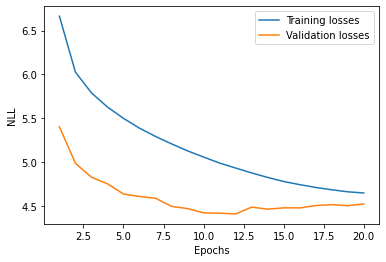

In [ ]:
plt.figure()
plt.plot(range(1, trainer.epochs + 1), trainer.train_losses, label='Training losses')
plt.plot(range(1, trainer.epochs + 1), trainer.val_losses, label='Validation losses')
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.legend()
plt.show()

In [ ]:
# TODO: Generate the handin to submit to autolab
!make runid=1682524312 epoch=12

cp hw4/experiments/1682524312/predictions-test-12.npy predictions.npy
cp hw4/experiments/1682524312/generated-12.txt generated.txt
cp hw4/experiments/1682524312/generated_logits-test-12.npy generated_logits.npy
cp hw4/hw4p1.ipynb training.ipynb
tar -cvf handin.tar training.ipynb predictions.npy generated.txt generated_logits.npy
training.ipynb
predictions.npy
generated.txt
generated_logits.npy
rm -f generated.txt predictions.npy training.ipynb generated_logits.npy


In [ ]:
!cp hw4/experiments/1682524312/predictions-test-12.npy predictions.npy
!cp hw4/experiments/1682524312/generated-12.txt generated.txt
!cp hw4/experiments/1682524312/generated_logits-test-12.npy generated_logits.npy
!cp hw4/hw4p1.ipynb training.ipynb
!tar -cvf handin.tar training.ipynb predictions.npy generated.txt generated_logits.npy

!rm -f generated.txt predictions.npy training.ipynb generated_logits.npy

training.ipynb
predictions.npy
generated.txt
generated_logits.npy


In [ ]:
!zip -r /bin/wandbRuns.zip /content/wandb

  adding: content/wandb/ (stored 0%)
  adding: content/wandb/run-20230407_080735-7m4v6v6i/ (stored 0%)
  adding: content/wandb/run-20230407_080735-7m4v6v6i/run-7m4v6v6i.wandb (deflated 79%)
  adding: content/wandb/run-20230407_080735-7m4v6v6i/files/ (stored 0%)
  adding: content/wandb/run-20230407_080735-7m4v6v6i/files/config.yaml (deflated 59%)
  adding: content/wandb/run-20230407_080735-7m4v6v6i/files/wandb-metadata.json (deflated 46%)
  adding: content/wandb/run-20230407_080735-7m4v6v6i/files/requirements.txt (deflated 55%)
  adding: content/wandb/run-20230407_080735-7m4v6v6i/files/output.log (deflated 36%)
  adding: content/wandb/run-20230407_080735-7m4v6v6i/files/wandb-summary.json (stored 0%)
  adding: content/wandb/run-20230407_080735-7m4v6v6i/tmp/ (stored 0%)
  adding: content/wandb/run-20230407_080735-7m4v6v6i/tmp/code/ (stored 0%)
  adding: content/wandb/run-20230407_080735-7m4v6v6i/logs/ (stored 0%)
  adding: content/wandb/run-20230407_080735-7m4v6v6i/logs/debug-internal.log

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

KeyError: ignored

In [ ]:
!google-drive-ocamlfuse /content/Drive


/bin/bash: google-drive-ocamlfuse: command not found


In [ ]:
!sudo apt-get update
!sudo apt-get install -y python3-pip
!sudo pip3 install google-auth google-auth-oauthlib google-auth-httplib2 google-api-python-client

Ign:1 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Hit:4 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:8 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:9 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:12 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:14 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Reading package list

In [ ]:
!sudo apt-get update

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1,581 B]
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ Packages [76.4 kB]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Get:9 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [995 kB]
Get:12 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:13 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InR

In [ ]:
!sudo apt-get install -y google-drive-ocamlfuse

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package google-drive-ocamlfuse


In [ ]:
!sudo add-apt-repository universe

'universe' distribution component is already enabled for all sources.
